1. Cargar y limpiar los datos
<!-- # Realice la limpieza de los datasets:
# - Renombre la columna "default payment next month" a "default".
# - Remueva la columna "ID".
# - Elimine los registros con informacion no disponible.
# - Para la columna EDUCATION, valores > 4 indican niveles superiores
#   de educación, agrupe estos valores en la categoría "others".
# - Renombre la columna "default payment next month" a "default"
# - Remueva la columna "ID". -->


In [1]:
# 1.1 Cargar datos de entrenamiento
import pandas as pd  #  type: ignore

train_data = pd.read_csv(
    "../files/input/train_data.csv.zip",
    index_col=False,
    compression="zip",
)
train_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,10748,310000,1,3,1,32,0,0,0,0,...,84373,57779,14163,8295,6000,4000,3000,1000,2000,0
1,12574,10000,2,3,1,49,-1,-1,-2,-1,...,1690,1138,930,0,0,2828,0,182,0,1
2,29677,50000,1,2,1,28,-1,-1,-1,0,...,45975,1300,43987,0,46257,2200,1300,43987,1386,0
3,8857,80000,2,3,1,52,2,2,3,3,...,40748,39816,40607,3700,1600,1600,0,1600,1600,1
4,21099,270000,1,1,2,34,1,2,0,0,...,22448,15490,17343,0,4000,2000,0,2000,2000,0


In [2]:
# 1.2 Cargar datos de prueba

test_data = pd.read_csv(
    "../files/input/test_data.csv.zip",
    index_col=False,
    compression="zip",
)
test_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
1,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0
2,11,200000,2,3,2,34,0,0,2,0,...,2513,1828,3731,2306,12,50,300,3738,66,0
3,15,250000,1,1,2,29,0,0,0,0,...,59696,56875,55512,3000,3000,3000,3000,3000,3000,0
4,16,50000,2,3,3,23,1,2,0,0,...,28771,29531,30211,0,1500,1100,1200,1300,1100,0


In [3]:
import numpy as np

# Paso 1: Realice la limpieza de los datasets

def limpiar(df):
    # Renombrar columna
    df = df.rename(columns={"default payment next month": "default"})
    # Eliminar columna 'ID'
    df.drop(columns=["ID"], inplace=True)
    # Modificar 'EDUCATION' (valores mayores a 4 se convierten en 4)
    df["EDUCATION"] = df["EDUCATION"].apply(lambda x: 4 if x > 4 else x)
    # Asignar NaN a valores de 'EDUCATION' menores o iguales a 0
    df["EDUCATION"] = df["EDUCATION"].apply(lambda x: x if x > 0 else np.nan)
    # Asignar NaN a valores de 'MARRIAGE' menores o iguales a 0
    df["MARRIAGE"] = df["MARRIAGE"].apply(lambda x: x if x > 0 else np.nan)
    # Eliminar filas con valores faltantes
    df.dropna(inplace=True)
    return df

# Aplicar la función a los datasets
train_data = limpiar(train_data)
test_data = limpiar(test_data)


2. Dividir los datos

In [4]:
# Divida los datasets en x_train, y_train, x_test, y_test
# x_train y x_test contienen  todas las columnas excepto la columna default.
# y_train y y_test contiene la variable objetivo default (pago)
x_train = train_data.drop(columns=["default"])
y_train = train_data["default"]

x_test = test_data.drop(columns=["default"])
y_test = test_data["default"]

3. Construir el pipeline

In [5]:
# Paso 3.
# Cree un pipeline para el modelo de clasificación. Este pipeline debe
# contener las siguientes capas:
# - Transforma las variables categoricas usando el método
#   one-hot-encoding.
# - Descompone la matriz de entrada usando componentes principales.
#   El pca usa todas las componentes.
# - Escala la matriz de entrada al intervalo [0, 1].
# - Selecciona las K columnas mas relevantes de la matrix de entrada.
# - Ajusta una red neuronal tipo MLP.

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)


# Identificar las columnas categóricas y numéricas
categorical_features = ['SEX','EDUCATION','MARRIAGE']
numerical_features= ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1','PAY_AMT2', 
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6' ]

# Crear el preprocesador con las transformaciones necesarias
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features),  
        ('num', StandardScaler(), numerical_features)  
    ]
)


# Crear el pipeline
pipeline=Pipeline(
    [
        ("preprocessor",preprocessor),
        ('feature_selection',SelectKBest(score_func=f_classif)),
        ('pca',PCA()),
        ('classifier',MLPClassifier(max_iter=15000,random_state=17))
    ]
)


# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(x_train, y_train)

# Evaluar el modelo en el conjunto de prueba
print("Modelo entrenado. Precisión en test:", pipeline.score(x_test, y_test))

Modelo entrenado. Precisión en test: 0.8281545829156922


In [16]:
# Paso 4.
# Optimice los hiperparametros del pipeline usando validación cruzada.
# Use 10 splits para la validación cruzada. Use la función de precision
# balanceada para medir la precisión del modelo.

# Parámetros para GridSearch
param_grid = {
            'pca__n_components': [None],
            'feature_selection__k':[20],
            "classifier__hidden_layer_sizes": [(50, 30, 40, 60)],
            'classifier__alpha': [0.26],
            "classifier__learning_rate_init": [0.001],
}


# Realizar GridSearchCV
grid_search = GridSearchCV(
                        estimator=pipeline,
                        param_grid=param_grid,
                        scoring='balanced_accuracy',  
                        cv=10,                                        
                        n_jobs=-1,                                  
                        verbose=1,
                        refit=True                              
)
grid_search.fit(x_train, y_train)




Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(),
                                                                         ['SEX',
                                                                          'EDUCATION',
                                                                          'MARRIAGE']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'PAY_0',
                                                                          'PAY_2',
                                                                          'PAY_3',
                                                                          'PAY_4',
                                                                          'PAY_5',
                                                                          'PAY_6',
                                                                          'BILL_AMT1',
                                                                          'BILL_AMT2',
                                                                          'BILL_AMT3',
                                                                          'BILL_AMT4',
                                                                          'BILL_AMT5',
                                                                          'BILL_AMT6',
                                                                          'PAY_AMT1',
                                                                          'PAY_AMT2',
                                                                          'PAY_AMT3',
                                                                          'PAY_A...
                                                                          'PAY_AMT6'])])),
                                       ('feature_selection', SelectKBest()),
                                       ('pca', PCA()),
                                       ('classifier',
                                        MLPClassifier(max_iter=15000,
                                                      random_state=17))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.26],
                         'classifier__hidden_layer_sizes': [(50, 30, 40, 60)],
                         'classifier__learning_rate_init': [0.001],
                         'feature_selection__k': [20],
                         'pca__n_components': [None]},
             scoring='balanced_accuracy', verbose=1)

5. Evaluacion del modelo

In [17]:
y_train_pred = grid_search.predict(x_train)
y_test_pred = grid_search.predict(x_test)


print("Score train", grid_search.score(x_train, y_train), ">", 0.661,) 
print("Score test", grid_search.score(x_test, y_test), ">", 0.666,)
print()

train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)

train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

print("train_precision", train_precision, ">", 0.691, train_precision > 0.691) 
print("train_balanced_accuracy", train_balanced_accuracy, ">", 0.661, train_balanced_accuracy > 0.661)
print("train_recall", train_recall, ">", 0.370, train_recall > 0.370)
print("train_f1", train_f1, ">", 0.482, train_f1 > 0.482) 
print()

print("test_precision", test_precision, ">", 0.673, test_precision > 0.673)
print("test_balanced_accuracy", test_balanced_accuracy, ">", 0.661, test_balanced_accuracy > 0.661)
print("test_recall", test_recall, ">", 0.370, test_recall > 0.370)
print("test_f1", test_f1, ">", 0.482, test_f1 > 0.482) 
print()

print(train_cm[0][0], 15440, train_cm[0][0] > 15440)
print(train_cm[1][1], 1735, train_cm[1][1] > 1735)
print(test_cm[0][0], 6710, test_cm[0][0] > 6710)
print(test_cm[1][1], 730, test_cm[1][1] > 730)

print('-------------------------')

Score train 0.6630025835547158 > 0.661
Score test 0.6695640976303335 > 0.666

train_precision 0.7025189924030388 > 0.691 True
train_balanced_accuracy 0.6630025835547158 > 0.661 True
train_recall 0.3718518518518519 > 0.37 True
train_f1 0.48629947412122887 > 0.482 True

test_precision 0.6846011131725418 > 0.673 True
test_balanced_accuracy 0.6695640976303335 > 0.661 True
test_recall 0.38719832109129065 > 0.37 True
test_f1 0.49463806970509383 > 0.482 True

15484 15440 True
1757 1735 True
6733 6710 True
738 730 True
-------------------------


6. Matriz de confusión

Matriz de Confusión (Train):
 [[15484   744]
 [ 2968  1757]]
Matriz de Confusión (Test):
 [[6733  340]
 [1168  738]]


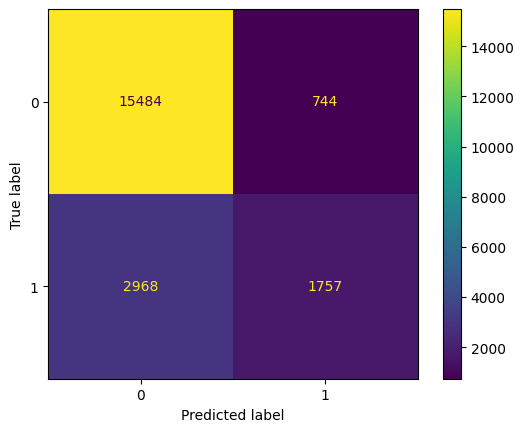

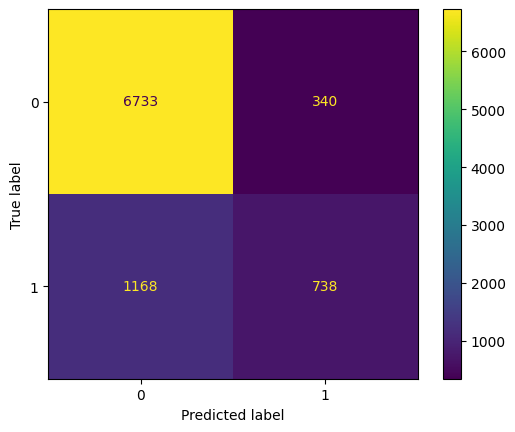

In [18]:
for dataset, y_true, y_pred in [("Train", y_train, y_train_pred), ("Test", y_test, y_test_pred)]:
    cm = confusion_matrix(y_true, y_pred)
    print(f"Matriz de Confusión ({dataset}):\n", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.classes_)
    disp.plot()

7. Guardar el modelo

In [19]:
# Guarde el modelo (comprimido con gzip) como "files/models/model.pkl.gz".
# Recuerde que es posible guardar el modelo comprimido usanzo la libreria gzip.

import pickle
import gzip

# Guardar el modelo comprimido con gzip
with gzip.open('../files/models/model.pkl.gz', 'wb') as file:
    pickle.dump(grid_search, file)

8. Calcular las métricas, matriz de confusión y guardarlas en json

In [20]:
import json
# Función para calcular las métricas de precisión, recall, etc.
def compute_metrics(model, X, y, dataset):
    y_pred = model.predict(X)
    metrics = classification_report(y, y_pred, output_dict=True)
    
    # formato de json
    results = {
        'type': 'metrics',
        'dataset': dataset,
        'precision': metrics['1']['precision'],
        'balanced_accuracy': balanced_accuracy_score(y, y_pred),
        'recall': metrics['1']['recall'],
        'f1_score': metrics['1']['f1-score']
    }
    return results

# Función para calcular la matriz de confusión
def compute_confusion_matrix(model, X, y, dataset):
    cm = confusion_matrix(y, model.predict(X))

    # formato de json
    return {
        'type': 'cm_matrix',
        'dataset': dataset,
        'true_0': {'predicted_0': int(cm[0][0]), 'predicted_1': int(cm[0][1])},
        'true_1': {'predicted_0': int(cm[1][0]), 'predicted_1': int(cm[1][1])}
    }

# Calcula las métricas para entrenamiento y prueba
metrics_list = [
    compute_metrics(grid_search.best_estimator_, x_train, y_train, 'train'),
    compute_metrics(grid_search.best_estimator_, x_test, y_test, 'test')
]

# Calcula la matriz de confusión para entrenamiento y prueba
cm_train = compute_confusion_matrix(grid_search.best_estimator_, x_train, y_train, 'train')
cm_test = compute_confusion_matrix(grid_search.best_estimator_, x_test, y_test, 'test')

# Crear una lista con todas las métricas y matrices
all_results = metrics_list + [cm_train, cm_test]

#Guardar todas las métricas y matrices en el archivo 'metrics.json'
with open('../files/output/metrics.json', 'w') as file:
    for result in all_results:
        file.write(json.dumps(result) + '\n')